# LIS3MDL Calibration

Below are a couple different methods to calibrate a magnetometer off line from some data. There are many more methods.

- Sensitivity ranges:
    - `RANGE_4GS` [default] (0.4 uT)
    - `RANGE_8GS`
    - `RANGE_12GS`
    - `RANGE_16GS`
- Sampling rate:
    - `ODR_155HZ` [default]
    - `ODR_300HZ`
    - `ODR_560HZ`
    - `ODR_1000HZ`
 
> WARNING: Even though sensitivity says Gauss, the sensor returns uT as the unit ... need to fix this?

NOAA WWMM: # https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm

![](wmm.png)

## References

- [Magnetometer Calibration](https://nbviewer.org/github/walchko/bearsnacks/blob/main/navigation-and-mapping/sensor-calibration/calibration-magnetometer/calibrate-magnetometer.ipynb)
- [Tutorial: How to calibrate a compass (and accelerometer) with Arduino](https://thecavepearlproject.org/2015/05/22/calibrating-any-compass-or-accelerometer-for-arduino/)
- [AN4246:  Calibrating an eCompass in the Presence of Hard and Soft-Iron Interference](https://www.nxp.com/docs/en/application-note/AN4246.pdf)
- [Alec Myer's blog on calibration](https://myahrs.wordpress.com/?s=calibration)

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
from matplotlib import pyplot as plt 
from magPlot import MagPlot,plotMagnetometer
from magPlot import calibrate, magcal
from serial import Serial
import datetime
import time
from the_collector import Collector

In [37]:
coll = Collector()
file = coll.read("../../../data/raw/magcal.pkl")
info = file["info"]
data = file["data"]

Loaded 12163 data points from:
--> ../../../data/raw/magcal.pkl


In [38]:
info

{'lis3mdl': {'mag_range_gs': 4,
  'samplerate_hz': 155,
  'date': '2023-09-26T12:12:57.778928'},
 'timestamp': '2023-09-26T12:14:14.540902'}

In [5]:
print("Loaded: ", len(data), " datapoints\n")
data[0]

Loaded:  12163  datapoints



{'x': -24.042677,
 'y': 37.459808,
 'z': -57.103184,
 'timestamp': 1695751977.932998}

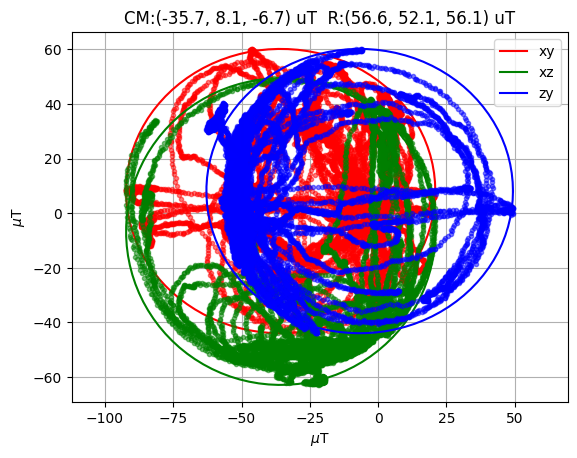

In [8]:
pts = [(d["x"], d["y"], d["z"]) for d in data]
pts = np.array(pts)
plotMagnetometer(pts)

## Calibrate

Qingde Li and John G.Griffiths, Least Squares Ellipsoid Specific Fitting, DOI: 10.1109/GMAP.2004.1290055, Source: IEEE Xplore

>> A:
[[0.01864725 0.00115632 0.00022873]
 [0.00115632 0.01862672 0.00017962]
 [0.00022873 0.00017962 0.01786376]]
>> b: [-34.88257367   8.14478089  -2.40830548]


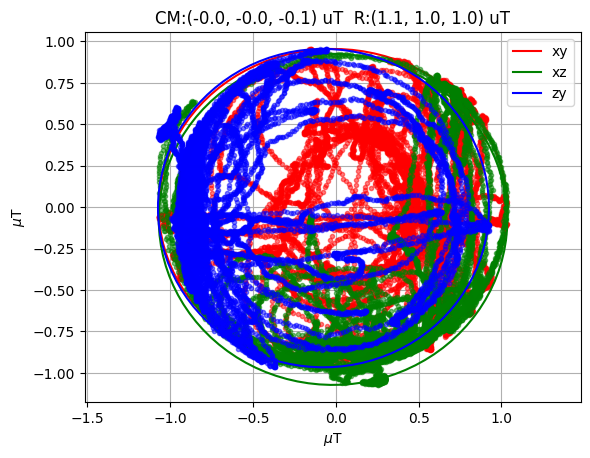

In [39]:
# uT = 48.512
uT = 1.0
A, b = calibrate(pts, uT)
print(f">> A:\n{A}")
print(f">> b: {b}")

corrected=(np.dot(A,(pts-b).T)).T
plotMagnetometer(corrected)

## Magcal

This is modelled after Matlab's [`magcal`](https://www.mathworks.com/help/nav/ref/magcal.html)

`[A,b,expmfs] = magcal(D)` returns the coefficients needed to correct uncalibrated magnetometer data D.

To produce the calibrated magnetometer data C, use equation C = (D-b)*A. The calibrated data C lies on a sphere of radius expmfs.

>> soft-iron correction:
[[0.01766133 0.         0.        ]
 [0.         0.01920831 0.        ]
 [0.         0.         0.01781307]]
>> hard-iron offset: [-33.55895929   7.77019354  -4.4485063 ]uT   expmfs: 54.1uT


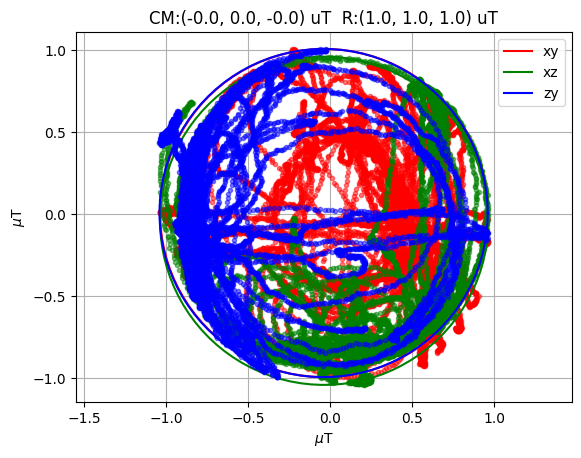

In [73]:
A,bb,fs = magcal(pts, uT)
print(f">> soft-iron correction:\n{A}")
print(f">> hard-iron offset: {bb}uT   expmfs: {fs:.1f}uT")
plotMagnetometer((pts-bb).dot(A))

[-0.59269592  0.14925229 -0.07924155]


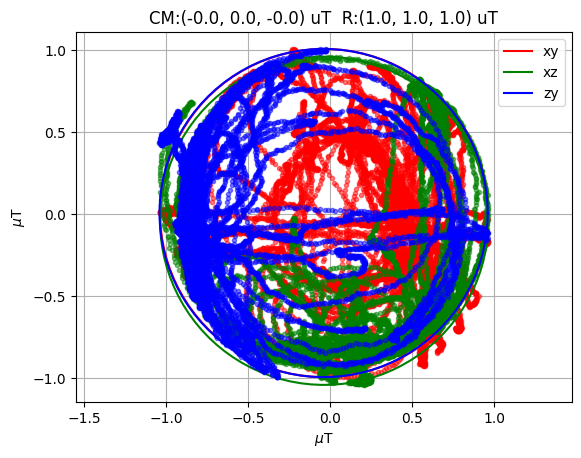

In [47]:
print(A.reshape())
print(A@bb)

plotMagnetometer(pts@A - A@bb)

In [71]:
# use in Arduino code
m = A.copy()
b = bb.copy().reshape((3,1))
mm = np.hstack((m, m@b)).reshape((1,12))
np.array2string(mm.ravel(), separator=',', formatter={'float_kind':lambda x: "%f" % x}, max_line_width=1000)

'[0.017661,0.000000,0.000000,-0.592696,0.000000,0.019208,0.000000,0.149252,0.000000,0.000000,0.017813,-0.079242]'